In [581]:
# imports
import torch
import keras
from keras import layers
from keras import models
from keras import optimizers
from keras.models import Sequential
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from keras.models import Model
import torch.nn.functional as func 
# import the necessary packages
import torch.nn as nn
from torch.nn import Module
from torch.nn import Conv1d
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
import torch.optim as optim
from torch import flatten
from torch.utils.data import TensorDataset, DataLoader
import h5py

In [582]:
f = h5py.File('/fast_scratch_1/QVAE/data/calo_scaled/piplus.hdf5', 'r')

In [583]:
list(f.keys())

['energy', 'layer_0', 'layer_1', 'layer_2', 'overflow']

In [554]:
triumf_ml1_dir = '/home/s4hoque/DwaveSampInteg'
# load data and process data
# piplus path
d1 = triumf_ml1_dir+'/CaloQVAE/outputs/2022-12-01/22-29-17/synthetic_images_piplus.pt'
d2 = triumf_ml1_dir+'/CaloQVAE/outputs/2022-11-30/22-26-46/synthetic_images_eplus.pt'
d1_data = torch.load(d1)
d2_data = torch.load(d2)
d1_tensor = torch.cat(d1_data) # not normalized
d2_tensor = torch.cat(d2_data) # not normalized
# define labels
d1_labels = torch.ones(d1_tensor.size(0)) # ones
d2_labels = torch.zeros(d2_tensor.size(0)) # zeros
# concat data and labels
inputs = torch.cat((d1_tensor, d2_tensor),dim=0)
labels = torch.cat((d1_labels, d2_labels), dim=0)
## NOT SHUFFLING HERE AS WE WANT TO SHUFFLE DIRECTLY THROUGH KERAS.FIT
dataset = TensorDataset(inputs, labels)
data_loader = DataLoader(dataset, shuffle=True, batch_size=inputs.size(0))
inputs = next(iter(data_loader))[0]
targets = next(iter(data_loader))[1]

In [555]:
print(targets)

tensor([1., 0., 0.,  ..., 1., 0., 1.])


In [556]:
# inputs = inputs.unsqueeze(-1)
# inputs.size()

In [573]:
class Net(nn.Module):
    """
    This class builds the neural network structure with 3 layers.
        Layer 1: num_features number of units
        layer 2: num_hiddden_units=100 hidden units seem to work well
        layer 3: num_classes=5 number of output classes
    """
    def __init__(self, num_features, num_hiddden_units, num_classes):
        super(Net, self).__init__() 
        self.fc1= nn.Linear(num_features, num_hiddden_units)
        self.fc2= nn.Linear(num_hiddden_units, num_classes) 
    
    def forward(self, x):
        h1 = torch.relu(self.fc1(x))
        h2 = func.dropout(self.fc2(h1),p=0.1)
        #h8 = torch.tanh(self.fch7(h7)) 
        y = h2
        return y

    def reset(self):
        self.fc1.reset_parameters()
        self.fc2.reset_parameters()

In [574]:
model = Net(num_features=504, num_hiddden_units=20, num_classes=1)


In [575]:
num_epochs=10000
display_epochs=500

In [576]:
outp = model.forward(inputs)

In [579]:
optimizer = optim.Adam(model.parameters(), lr=0.2)
loss = torch.nn.L1Loss(reduction= 'mean')
obj_vals= []  
for epoch in range(num_epochs):   
    model_output = model.forward(inputs).reshape(-1)
    pred = (model_output>0.5).float()
    diff_tensor =  pred - targets 
    diff_tensor = torch.abs(diff_tensor)
    accuracy = 1-torch.sum(diff_tensor)/pred.size(0)
    obj_val = loss(model_output, targets)
    optimizer.zero_grad() 
    obj_val.backward() 
    optimizer.step() 
    obj_vals.append(obj_val.item())
    if (epoch+1) % display_epochs == 0:
        print ('Epoch [{}/{}]\tTrain Loss :{:.4f}\t accuracy :{:.4f}%'.format(epoch+1, num_epochs, obj_val.item(), accuracy*100))
print("\nTraining Completed")

Epoch [500/10000]	Train Loss :0.4989	 accuracy :50.0000%
Epoch [1000/10000]	Train Loss :0.5002	 accuracy :49.9609%
Epoch [1500/10000]	Train Loss :0.5003	 accuracy :49.9365%
Epoch [2000/10000]	Train Loss :0.5018	 accuracy :49.7119%
Epoch [2500/10000]	Train Loss :0.5013	 accuracy :49.8438%
Epoch [3000/10000]	Train Loss :0.5027	 accuracy :49.6289%
Epoch [3500/10000]	Train Loss :0.4986	 accuracy :50.2295%
Epoch [4000/10000]	Train Loss :0.4995	 accuracy :50.0830%
Epoch [4500/10000]	Train Loss :0.5001	 accuracy :50.0000%
Epoch [5000/10000]	Train Loss :0.4987	 accuracy :50.0000%
Epoch [5500/10000]	Train Loss :0.5004	 accuracy :49.9463%
Epoch [6000/10000]	Train Loss :0.4998	 accuracy :50.0244%
Epoch [6500/10000]	Train Loss :0.4980	 accuracy :50.2295%
Epoch [7000/10000]	Train Loss :0.5008	 accuracy :49.9072%
Epoch [7500/10000]	Train Loss :0.5007	 accuracy :50.0000%
Epoch [8000/10000]	Train Loss :0.5011	 accuracy :50.0000%
Epoch [8500/10000]	Train Loss :0.4996	 accuracy :50.0000%
Epoch [9000/100

In [ ]:
plt.plot(range(num_epochs), obj_vals)

--- Logging error ---
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 461, in dispatch_queue
    await self.process_one()
  File "/opt/conda/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 450, in process_one
    await dispatch(*args)
TypeError: object NoneType can't be used in 'await' expression

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/logging/__init__.py", line 1089, in emit
    self.flush()
  File "/opt/conda/lib/python3.8/logging/__init__.py", line 1069, in flush
    self.stream.flush()
OSError: [Errno 5] Input/output error
Call stack:
  File "/opt/conda/lib/python3.8/runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/opt/conda/lib/python3.8/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/opt/conda/lib/python3.8/site-packages/ipykernel_launch

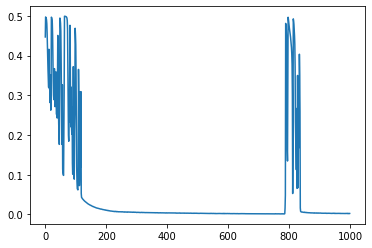

In [362]:
plt.plot(range(num_epochs), obj_vals)

In [446]:
final_out = model.forward(inputs)
i = 10200
while i<10400:
    print("out is {0} for label {1}".format(final_out[i], labels[i]))
    i = i + 1

IndexError: index 10200 is out of bounds for dimension 0 with size 8000

--- Logging error ---
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 461, in dispatch_queue
    await self.process_one()
  File "/opt/conda/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 450, in process_one
    await dispatch(*args)
TypeError: object NoneType can't be used in 'await' expression

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/logging/__init__.py", line 1089, in emit
    self.flush()
  File "/opt/conda/lib/python3.8/logging/__init__.py", line 1069, in flush
    self.stream.flush()
OSError: [Errno 5] Input/output error
Call stack:
  File "/opt/conda/lib/python3.8/runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/opt/conda/lib/python3.8/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/opt/conda/lib/python3.8/site-packages/ipykernel_launch